In [1]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#from scipy.stats import binned_statistic
from os.path import exists

In [2]:
UnitVelocity_in_cm_per_s = 1e5		
UnitVelocity_in_km_per_s = UnitVelocity_in_cm_per_s / 1e5
UnitLength_in_cm = 3.085678e18 	# pc
UnitLength_in_pc = UnitLength_in_cm / 3.085678e18
UnitMass_in_g = 1.989e31		# 0.01 solar masses
UnitMass_in_Msun = UnitMass_in_g / 1.989e33

yr_to_sec = 60 * 60 * 24 * 365
sec_to_yr = 1 / yr_to_sec
cm_to_km = 1 / 1e5
cm_to_pc = 1 / 3.085678e18
UnitEnergy_in_erg = UnitMass_in_g * UnitVelocity_in_cm_per_s**2
UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
UnitTime_in_yr = UnitTime_in_s * sec_to_yr

#for temperature calculation:
kB_SI = 1.38e-23 #J/K
kB_cgs = kB_SI * 1e7
X_H = 0.76 # hydrogen mass fraction
gamma = 5/3
m_p = 1.67e-24 # proton mass in g

In [3]:
def LoadAnalyticalSolutions(nSN = 1):
    if(nSN == 1):
        with h5py.File("analyticalSolution/maxRadVelData_80k_years_1_star_n0_1.hdf5", "r") as hdf:
            radVelData = np.array(hdf.get("Data/RadVels_n0_1"))
            timeData = np.array(hdf.get("Data/Times_n0_1"))
        return timeData, radVelData
        #with h5py.File("analyticalSolution/maxRadVelData_80k_years_1e51erg_p_1e-1.hdf5", "r") as hdf:
        #    radVelData = np.array(hdf.get("Data/RadVelsp1e-1"))
        #    timeData = np.array(hdf.get("Data/Timesp1e-1"))
        #return timeData, radVelData
    elif(nSN == 10):
        with h5py.File("analyticalSolution/maxRadVelData_80k_years_10_SNe.hdf5", "r") as hdf:    
            radVelData10 = np.array(hdf.get("Data/RadVels10"))
            timeData10 = np.array(hdf.get("Data/Times10"))
        return timeData10, radVelData10
    elif(nSN == 100):
        with h5py.File("analyticalSolution/maxRadVelData_80k_years_100_SNe.hdf5", "r") as hdf:    
            radVelData100 = np.array(hdf.get("Data/RadVels100"))
            timeData100 = np.array(hdf.get("Data/Times100"))
        return timeData100, radVelData100
    elif(nSN == 0.43):
        with h5py.File("analyticalSolution/maxRadVelData_80k_years_1e43erg.hdf5", "r") as hdf:    
            radVelData1e43 = np.array(hdf.get("Data/RadVels1e43"))
            timeData1e43 = np.array(hdf.get("Data/Times1e43"))
        return timeData1e43, radVelData1e43
        
        
        
# Load Data

def LoadDataFromHDF(folder, timeStep, dataName):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        data = np.array(hdf.get("PartType0/"+dataName))
    return data

def getVelocities(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        velocities = np.array(hdf.get("PartType0/Velocities"))
    return velocities

def getMasses(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        masses = np.array(hdf.get("PartType0/Masses"))
    return masses

def getDensities(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        densities = np.array(hdf.get("PartType0/Density"))
    return densities

def getCoos(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        coos = np.array(hdf.get("PartType0/Coordinates"))
    return coos

def getSFRs(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        sfrs = np.array(hdf.get("PartType0/StarFormationRate"))
    return sfrs

def getStarsExploded(folder, timeStep):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        try:
            hdf['PartType4']
        except KeyError:
            starsExploded = np.zeros(1)
        else:
            starsExploded = np.array(hdf.get("PartType4/StarsExploded"))
            if(starsExploded.all() == None):
                starsExploded = np.zeros(1)
    return starsExploded

def T(internalEnergy, electronAbundance): #input in codeunits output in Kelvin
    x_e = electronAbundance
    u = internalEnergy
    
    my = 4/(1 + 3 * X_H + 4 * X_H * x_e) * m_p # meanMolecularWeight
    T = (gamma - 1) * u / kB_cgs * UnitEnergy_in_erg / UnitMass_in_g * my
    return T

def getTemperaturesInKelvin(folder, timeStep, debugOn = False):
    energies = LoadDataFromHDF(folder, timeStep, "InternalEnergy")
    electronAbundance = LoadDataFromHDF(folder, timeStep, "ElectronAbundance")
    
    temperatures = T(energies, electronAbundance)
    
    if(timeStep == 0):
        print("initial temperature: " + str(temperatures[0]) + "K")
    if(debugOn):
        print("max temp: " + str(np.max(temperatures)))
        print("min temp: " + str(np.min(temperatures)))
    
    return temperatures


# Usefull stuff

def getRadialDistances(folder, timeStep):
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")
    radDirs = coos - np.full(3,boxSize/2)
    radDirsNorm = np.sqrt((radDirs*radDirs).sum(axis=1))
    return radDirsNorm



# Velocity

def getRadialGasVelocities(folder, timeStep):
    vels = LoadDataFromHDF(folder, timeStep, "Velocities")
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")
    
    radDirs = coos - np.full(3,boxSize/2)
    radDirsNorm = np.sqrt((radDirs*radDirs).sum(axis=1))
    normedRadDirs = radDirs / radDirsNorm[:,None] # radDirs: (n,3); radDirsNorm: (n,1)

    radVels = vels * normedRadDirs
        
    return radVels

def getMaxRadialGasVelocity(folder, timeStep): # maxRadVels
    radVels = getRadialGasVelocities(folder, timeStep)
    return np.max(radVels)

def getAbsoluteVelocities(folder, timeStep):
    velocities = LoadDataFromHDF(folder, timeStep, "Velocities")
    absoluteVelocities = np.sqrt((velocities*velocities).sum(axis=1))
    return absoluteVelocities


def getMaxGasVelocity(folder, timeStep):    
    absVelocities = getAbsoluteVelocities(folder, timeStep)
    return np.max(absVelocities)



# Momentum

def getMomenta(folder, timeStep):
    absVelocities = getAbsoluteVelocities(folder, timeStep)
    masses = getMasses(folder, timeStep)
    momenta = masses * absVelocities
    return momenta

def getTotalMomentum(folder, timeStep): # totalMomentum
    momenta = getMomenta(folder, timeStep)
    totalMomentum = np.sum(momenta)
    return totalMomentum




# Energy

def getMaxEnergy(folder, timeStep):
    internalEnergies = LoadDataFromHDF(folder, timeStep, "InternalEnergy")
    return np.max(internalEnergies)

def getTotalInternalEnergy(folder, timeStep):
    internalEnergies = LoadDataFromHDF(folder, timeStep, "InternalEnergy")
    return np.sum(internalEnergies)

def getTotalKineticEnergy(folder, timeStep):
    masses = LoadDataFromHDF(folder, timeStep, "Masses")
    absVelocities = getAbsoluteVelocities(folder, timeStep)
    kineticEnergies = 0.5 * masses * absVelocities*2
    return np.sum(kineticEnergies)

def getTotalEnergy(folder, timeStep):
    internalEnergy = getTotalInternalEnergy(folder, timeStep)
    kineticEnergy = getTotalKineticEnergy(folder, timeStep)
    totalEnergy = internalEnergy + kineticEnergy
    return totalEnergy

def getTotalStarsExploded(folder, timeStep):
    starsExploded = getStarsExploded(folder, timeStep)
    totalStarsExploded = np.sum(starsExploded)
    return totalStarsExploded

def getStarsExplodedThisTimeStep(folder, timeStep):
    totalStarsExploded = getTotalStarsExploded(folder, timeStep)
    if(timeStep == 0):
        return totalStarsExploded
    lastStepTotalStarsExploded = getTotalStarsExploded(folder, timeStep-1)
    return totalStarsExploded - lastStepTotalStarsExploded



# SNR Radius


# for ana solution, or loaded radVels

def getRadiiFromRadialVelocities(radVels, timeBetweenEntries): # input: array of max radVels of all timeSteps (for ana solution)
    radii = radVels
    for i in range(1, len(radVels)):
        radii[i] += radii[i-1]
    radii *= timeBetweenEntries
    return radii


# radius via integration of radVels

def getIncreasOfRadiusInThisTimeStep(radVels, timeBetweenEntries):
    return np.max(radVels) * timeBetweenEntries

def maxRadVelIntegrationRadius(folder, timeStep, oldRadius):
    radVels = getRadialGasVelocities(folder, timeStep)
    snrRadius = oldRadius + getIncreasOfRadiusInThisTimeStep(radVels, TimeBetSnapshot_in_unit_time)
    return snrRadius

# radius via particle-density profile maximum

def densityProfileRadius(folder, timeStep, bins):
    radDists = getRadialDistances(folder, timeStep)
    blastwave = np.zeros(len(bins))
    for i in range(len(coos)):
        for j in range(len(bins)-1):
            if(radDists[i] >= bins[j] and radDists[i] < bins[j+1]):
                blastwave[j] += 1#densities[i] / radDists[i] ** 2
                
    return np.where(blastwave == np.max(blastwave))[0][0]

# radius via point of max density

def maxDensityRadius(folder, timeStep): # maxDensityRadii
    coos = getCoos(folder, timeStep)
    densities = getDensities(folder, timeStep)
    highestDensityIndex = np.where(densities == np.max(densities))[0][0]
    radius = np.sqrt((coos[highestDensityIndex,0] - boxSize/2)**2 + 
                     (coos[highestDensityIndex,1] - boxSize/2)**2 + 
                     (coos[highestDensityIndex,2] - boxSize/2)**2)
    return radius

# radius via velocity cut

def velocityCutRadius(folder, timeStep, debugOn = False): # velocityCutRadii
    absVelocities = getAbsoluteVelocities(folder, timeStep)
    distsFromCenter = getRadialDistances(folder, timeStep)
    
    if(debugOn):
        print(f"{absVelocities}")
        print(f"{distsFromCenter}")
    
    velocityCut_in_km_per_s = 1
    velocityCut_in_Unit_velocity = velocityCut_in_km_per_s / UnitVelocity_in_km_per_s
    particlesWithEnoughVelocity = distsFromCenter[np.where(absVelocities > velocityCut_in_Unit_velocity)]
    
    if(len(particlesWithEnoughVelocity) > 0):
        radius = np.max(particlesWithEnoughVelocity)
        return radius
    else:
        return 0
    






# input radii of all timesteps

def shellVelocitiesFromRadii(radii):
    shellVelocities = np.zeros(len(radii))
    shellVelocities[0] = radii[0] * UnitLength_in_cm / 1e3 / TimeBetSnapshot_in_s
    shellVelocities[1:] = (radii[1:] - radii[:-1]) * UnitLength_in_cm / 1e3 / TimeBetSnapshot_in_s
    
    return shellVelocities # in km/s

def RadiiFromShellVelocities(vels):
    radii = vels * TimeBetSnapshot_in_unit_time
    for i in range(len(vels)):
        if(i == 0):
            continue
        radii[i] += radii[i-1]
    return radii



def getTotalSFR(folder, timeStep): # SFR
    sfrs = getSFRs(folder, timeStep)
    #print(sfrs)
    totalSFR = np.sum(sfrs)
    #print(totalSFR)
    return totalSFR

In [4]:
def calculateOrLoadData(folder, folderName, dataName, calcDataOfOneSnapShotFunction, frameAmount, recalculate = False):
    if(exists("data/"+dataName+folderName) and recalculate == False):
        #load data
        print("load data")
        data = np.loadtxt("data/"+dataName+folderName)
        if(len(data) < frameAmount):
            print("create more data")
            newData = np.zeros(frameAmount)
            
            dh = display(0,display_id=True)
            
            for timeStep in range(frameAmount):
                newData[timeStep] = calcDataOfOneSnapShotFunction(folder, timeStep)
                dh.update(timeStep)
                np.savetxt("data/"+dataName+folderName, newData)
            return newData
        else:
            return data[:frameAmount]
    else:
        if(recalculate):
            print("recalculate data")
        else:
            print("calculate data")
        data = np.zeros(frameAmount)
        
        dh = display(0,display_id=True)
            
        #calculate and save new data
        for timeStep in range(frameAmount):
            data[timeStep] = calcDataOfOneSnapShotFunction(folder, timeStep)
            dh.update(timeStep)

            np.savetxt("data/"+dataName+folderName, data)
        return data
    

def PlotData(data, folderNames, title, ylabel, dataName, unit_conversion_factor, frameAmount, frameNbrMultiplier, xlabel = "time [yr]", compareToAnalyticVelocities = False, compareToAnalyticRadius = False):
    plt.clf()
    
    TimeBetSnapshot_in_s = TimeBetSnapshot_in_unit_time * UnitTime_in_s
    TimeBetSnapshot_in_yr = TimeBetSnapshot_in_s * sec_to_yr
    timeScaleToYears = np.linspace(0,TimeBetSnapshot_in_yr*(frameAmount-1),frameAmount)

    
    for i in range(len(folderNames)):
        plt.plot(timeScaleToYears[1:frameAmount]*frameNbrMultiplier, data[i][1:frameAmount] * unit_conversion_factor, label=folderNames[i])
    
    if(compareToAnalyticVelocities):
        timeData, radVelData = LoadAnalyticalSolutions()
        plt.plot(timeData * sec_to_yr, radVelData * cm_to_km, label="Sedov Taylor Radial Velocity")
    elif(compareToAnalyticRadius):
        timeData, radVelData = LoadAnalyticalSolutions()
        radii = RadiiFromShellVelocities(radVelData)
        plt.plot(timeData * sec_to_yr, radii * cm_to_km, label="Sedov Taylor Shell Radius")

    plt.yscale("log")
    plt.title(title)
    plt.legend()
    #plt.legend(["1 star center", "10 stars center", "100 stars center", "10 stars flat dist", "100 stars flat dist", "analytical 1 SN", "analytical 10 SNe", "analytical 100 SNe"])
    #plt.legend(["1 star", "10 stars r=10pc", "10 stars t=5kyr", "10 stars r=10pc t=5kyr"])
    plt.xlabel(xlabel)
    #plt.ylabel("Max velocity ["+str(round(UnitVelocity_in_km_per_s))+ " km/s]")
    plt.ylabel(ylabel)
    fig = plt.figure()#figsize=(16.18 * 2, 10 * 2))
    #fig.set_dpi(150.0)
    #fig.patch.set_facecolor('xkcd:mint green')
    saveName = "plots/"+dataName
    for i in range(len(folderNames)):
        saveName += "-"+folderNames[i]
    plt.savefig(saveName)#, facecolor='w')

    plt.show()

### Cluster

In [6]:
folderPath = "/vera/ptmp/gc/xboecker/run/5_SN_cluster_final/"
folderNames = ["0_base_with_IO_fields", "1_density_0_5", "1_density_10",  "2_stars_5", "2_stars_100", "3_rad_5pc", "3_rad_40pc", "4_tempRad_5kyr", "4_tempRad_50kyr"]
#folderPath = "/u/xboecker/run/3_multiple_SNe/"
#folderNames = ["0_1_star", "1_stars_10_linear_spacial_distribution_rad_10", "2_stars_10_linear_temporal_distribution_temp_5kyr", "3_stars_10_linear_spacial_and_temporal_distribution_rad_10pc_temp_5kyr"]
dataFolders = np.full(len(folderNames),"string long enough so that no entry will be longer than this, because then is would be cut off......................................................................................")

for i in range(len(folderNames)):
    dataFolders[i] = folderPath+folderNames[i]+"/output"
    

boxSize = 96
frameAmount = 40
frameNbrMultiplier = 10
TimeBetSnapshot_in_unit_time = 0.002

### SNR Radius

load data
load data
load data
load data
load data
load data
load data
load data
load data


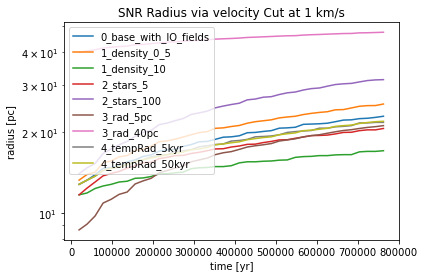

<Figure size 432x288 with 0 Axes>

In [6]:
radiiArray = np.full((len(folderNames), frameAmount), 0, dtype = np.float64)

for i in range(len(folderNames)):
    radiiArray[i] = calculateOrLoadData(folder = dataFolders[i], 
                                        folderName = folderNames[i], 
                                        dataName = "velocityCutRadii", 
                                        calcDataOfOneSnapShotFunction = velocityCutRadius,
                                        frameAmount = frameAmount, 
                                        recalculate = False)




PlotData(data = radiiArray, 
         folderNames = folderNames, 
         title = "SNR Radius via velocity Cut at 1 km/s", 
         ylabel = "radius [pc]", 
         dataName = "velocityCutRadii", 
         unit_conversion_factor = 1,
         frameAmount = frameAmount, 
         frameNbrMultiplier = frameNbrMultiplier,
         compareToAnalyticRadius = False)


### Total Momentum

load data
load data
load data
load data
load data
load data
load data
load data
load data


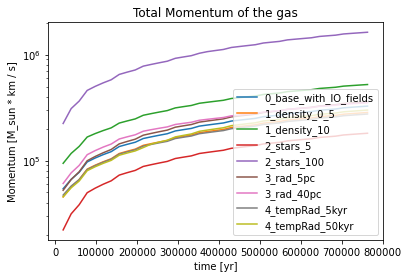

<Figure size 432x288 with 0 Axes>

In [7]:
dataNameForSaveFiles = "totalMomentum"
plotTitle = "Total Momentum of the gas"
plot_yLabel = "Momentum [M_sun * km / s]"
unitConversionFactor = UnitMass_in_Msun * UnitVelocity_in_km_per_s
functionToComputeData = getTotalMomentum

dataArray = np.full((len(folderNames), frameAmount), 0, dtype = np.float64)

for i in range(len(folderNames)):
    dataArray[i] = calculateOrLoadData(folder = dataFolders[i], 
                                        folderName = folderNames[i], 
                                        dataName = dataNameForSaveFiles, 
                                        calcDataOfOneSnapShotFunction = functionToComputeData, 
                                        frameAmount = frameAmount, 
                                        recalculate = False)




PlotData(data = dataArray, 
         folderNames = folderNames, 
         title = plotTitle, 
         ylabel = plot_yLabel, 
         dataName = dataNameForSaveFiles, 
         unit_conversion_factor = unitConversionFactor,
         frameAmount = frameAmount, 
         frameNbrMultiplier = frameNbrMultiplier,
         compareToAnalyticRadius = False)

### max radial Velocity

load data
load data
load data
load data
load data
load data
load data
load data
load data


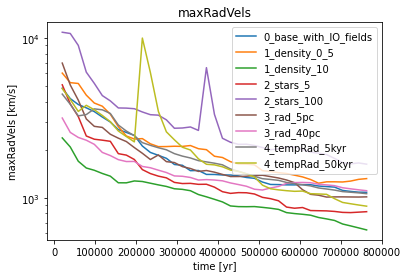

<Figure size 432x288 with 0 Axes>

In [8]:
maxRadVelArray = np.full((len(folderNames), frameAmount), 0, dtype = np.float64)

for i in range(len(folderNames)):
    maxRadVelArray[i] = calculateOrLoadData(folder = dataFolders[i], 
                                            folderName = folderNames[i], 
                                             dataName = "maxRadVels", 
                                             calcDataOfOneSnapShotFunction = getMaxRadialGasVelocity, 
                                        frameAmount = frameAmount, 
                                             recalculate = False)

PlotData(data = maxRadVelArray, 
         folderNames = folderNames, 
         title = "maxRadVels", 
         ylabel = "maxRadVels [km/s]", 
         dataName = "maxRadVels", 
         unit_conversion_factor = UnitVelocity_in_km_per_s,
         frameAmount = frameAmount, 
         frameNbrMultiplier = frameNbrMultiplier,
         compareToAnalyticVelocities = False)

### Terminal Momentum Plots

Literatur:
https://academic.oup.com/mnras/article/492/1/1243/5670636
terminal momentum of 1SN: 3.000 M_sun km/s
11SNe: 35.000 M_sun km/s (0.6pc resolution)
11SNe: 25.000 M_sun km/s ( 20pc resolution)

 Hopkins et al. (2018b) prescribe ∼5 × 10^5 M⊙*N_SNe*km/s of momentum per SN (at ρ = 1.33mH cm−3)
 
 
Martizzi: https://academic.oup.com/mnras/article/450/1/504/998665 (Fig. 4)
1SN, n=100 cm-3 --> radial momentum of the shock 1e43 g*cm/s ~ 1e6 M_sun*km/s

In [7]:
folderPath = "/vera/ptmp/gc/xboecker/run/5_SN_cluster_final/"
folderNames = ["0_base_with_IO_fields", "1_density_0_5", "1_density_10",  "2_stars_5", "2_stars_100", "3_rad_5pc", "3_rad_40pc", "4_tempRad_5kyr", "4_tempRad_50kyr"]
dataFolders = np.full(len(folderNames),"string long enough so that no entry will be longer than this, because then is would be cut off......................................................................................")

for i in range(len(folderNames)):
    dataFolders[i] = folderPath+folderNames[i]+"/output"
    

lastFrame = 400

terminalMomenta =  np.zeros(len(folderNames))

for i in range(len(folderNames)):
    terminalMomenta[i] = getTotalMomentum(dataFolders[i], lastFrame)
terminalMomenta

array([1.31235456e+08, 1.05959816e+08, 1.76004544e+08, 7.32344080e+07,
       4.18324736e+08, 1.44222688e+08, 1.16620160e+08, 1.15659488e+08,
       1.22415776e+08])

In [8]:
densities = np.zeros(len(folderNames))
nStar = np.array([10,10,10,5,100,10,10,10,10])
rad = np.array([0,0,0,0,0,5,40,0,0])
tempRad = np.array([0,0,0,0,0,0,0,5,50])
for i in range(len(folderNames)):
    densities[i] = getDensities(dataFolders[i], 0)[0]
densities /= densities[0]

#### Density vs n_star

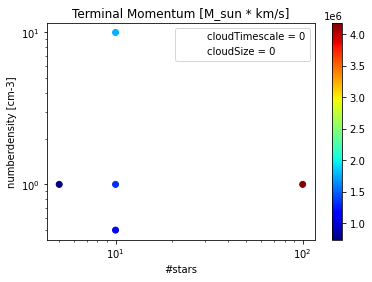

In [17]:
empty_patch = mpatches.Patch(color='none', label="cloudTimescale = 0") 
empty_patch2 = mpatches.Patch(color='none', label="cloudSize = 0") 
plt.legend(handles=[empty_patch, empty_patch2])

plt.scatter(nStar[:5], densities[:5], c=terminalMomenta[:5] * UnitMass_in_Msun * UnitVelocity_in_km_per_s, cmap="jet", vmin = np.min(terminalMomenta) * UnitMass_in_Msun * UnitVelocity_in_km_per_s, vmax = np.max(terminalMomenta) * UnitMass_in_Msun * UnitVelocity_in_km_per_s)
plt.title("Terminal Momentum [M_sun * km/s]")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("#stars")
plt.ylabel("numberdensity [cm-3]")
plt.colorbar()

#### CloudSize vs TimeScale

Text(0, 0.5, 'cloudSize [pc]')

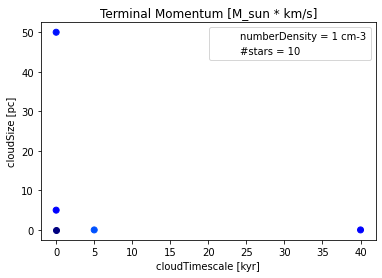

In [18]:
empty_patch = mpatches.Patch(color='none', label="numberDensity = 1 cm-3") 
empty_patch2 = mpatches.Patch(color='none', label="#stars = 10") 
plt.legend(handles=[empty_patch, empty_patch2])
plt.scatter(rad[5:], tempRad[5:], c=terminalMomenta[5:] * UnitMass_in_Msun * UnitVelocity_in_km_per_s, cmap="jet", vmin = np.min(terminalMomenta) * UnitMass_in_Msun * UnitVelocity_in_km_per_s, vmax = np.max(terminalMomenta) * UnitMass_in_Msun * UnitVelocity_in_km_per_s)
plt.scatter(rad[0], tempRad[0], c=terminalMomenta[0] * UnitMass_in_Msun * UnitVelocity_in_km_per_s, cmap="jet")
plt.title("Terminal Momentum [M_sun * km/s]")
plt.xlabel("cloudTimescale [kyr]")
plt.ylabel("cloudSize [pc]")

### Galaxy

In [5]:
UnitVelocity_in_cm_per_s = 1e5		
UnitVelocity_in_km_per_s = UnitVelocity_in_cm_per_s / 1e5
UnitLength_in_cm = 3.085678e21 	# kpc---------------------------
UnitLength_in_pc = UnitLength_in_cm / 3.085678e18
UnitMass_in_g = 1.989e43		# 1e10 solar masses-------------
UnitMass_in_Msun = UnitMass_in_g / 1.989e33

UnitDensity_in_cgs = UnitMass_in_g / UnitLength_in_cm**3

yr_to_sec = 60 * 60 * 24 * 365
sec_to_yr = 1 / yr_to_sec
cm_to_km = 1 / 1e5
cm_to_pc = 1 / 3.085678e18
UnitEnergy_in_erg = UnitMass_in_g * UnitVelocity_in_cm_per_s**2
UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
UnitTime_in_yr = UnitTime_in_s * sec_to_yr



galaxyFolderPath = "/vera/ptmp/gc/xboecker/run/4_galaxy/xeno_diskIC/run_diskIC_wdm/"
#galaxyFolderNames = ["output_cooling_SFR", "output_cooling_SFR_xenoSN", "output_cooling_SFR_eEOS_changed", "output_cooling_SFR_xenoSN_eEOS_changed"]
galaxyFolderNames = ["output_cooling_SFR_eEOS_changed", "output_cooling_SFR_xenoSN_eEOS_changed", "output_cooling_SFR_xenoSN_eEOS_changed_1_percent_energy", "output_cooling_SFR_xenoSN_eEOS_changed_100x_energy", "output_cooling_SFR_xenoSN_eEOS_changed_100kx_energy"]
galaxyDataFolders = np.full(len(galaxyFolderNames),"string long enough so that no entry will be longer than this, because then is would be cut off......................................................................................")

for i in range(len(galaxyFolderNames)):
    galaxyDataFolders[i] = galaxyFolderPath+galaxyFolderNames[i]
    

#galaxyBoxSize = 200
galaxyFrameAmount = 300
galaxyFrameNbrMultiplier = 1
TimeBetSnapshot_in_unit_time = 0.01 # ----------

In [23]:
folder = galaxyDataFolders[0]
timeStep = 20
with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        masses = np.array(hdf.get("PartType4/Masses"))
        print(masses)

[2.55423e-05 2.55423e-05 2.55423e-05 ... 2.55423e-05 2.55423e-05
 2.55423e-05]


### SFR

load data
load data
load data
load data
load data


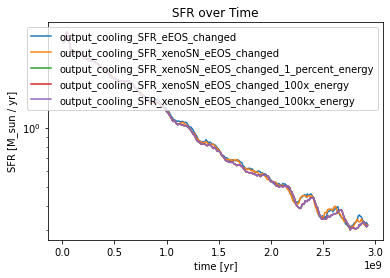

<Figure size 432x288 with 0 Axes>

In [24]:
sfrArray = np.full((len(galaxyFolderNames), galaxyFrameAmount), 0, dtype = np.float64)

for i in range(len(galaxyFolderNames)):
    sfrArray[i] = calculateOrLoadData(folder = galaxyDataFolders[i], 
                                        folderName = galaxyFolderNames[i], 
                                        dataName = "SFR", 
                                        calcDataOfOneSnapShotFunction = getTotalSFR, 
                                        frameAmount = galaxyFrameAmount, 
                                        recalculate = False)



PlotData(data = sfrArray, 
         folderNames = galaxyFolderNames, 
         title = "SFR over Time", 
         ylabel = "SFR [M_sun / yr]", 
         dataName = "SFR", 
         unit_conversion_factor = 1,
         frameAmount = galaxyFrameAmount, 
         frameNbrMultiplier = galaxyFrameNbrMultiplier,
         compareToAnalyticRadius = False)

### Stars Exploded vs Time

#### Total #SN

calculate data


299

calculate data


299

calculate data


299

calculate data


299

calculate data


299

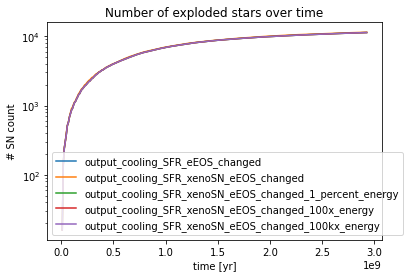

<Figure size 432x288 with 0 Axes>

In [6]:
dataArray = np.full((len(galaxyFolderNames), galaxyFrameAmount), 0, dtype = np.float64)

for i in range(len(galaxyFolderNames)):
    dataArray[i] = calculateOrLoadData(folder = galaxyDataFolders[i], 
                                        folderName = galaxyFolderNames[i], 
                                        dataName = "totalStarsExploded", 
                                        calcDataOfOneSnapShotFunction = getTotalStarsExploded, 
                                        frameAmount = galaxyFrameAmount, 
                                        recalculate = False)



PlotData(data = dataArray, 
         folderNames = galaxyFolderNames, 
         title = "Number of exploded stars over time", 
         ylabel = "# SN count", 
         dataName = "totalStarsExploded", 
         unit_conversion_factor = 1,
         frameAmount = galaxyFrameAmount, 
         frameNbrMultiplier = galaxyFrameNbrMultiplier,
         compareToAnalyticRadius = False)

#### SN rate

calculate data


299

calculate data


299

calculate data


299

calculate data


299

calculate data


299

OSError: [Errno 36] File name too long: 'plots/starsExplodedThisTimeStep-output_cooling_SFR_eEOS_changed-output_cooling_SFR_xenoSN_eEOS_changed-output_cooling_SFR_xenoSN_eEOS_changed_1_percent_energy-output_cooling_SFR_xenoSN_eEOS_changed_100x_energy-output_cooling_SFR_xenoSN_eEOS_changed_100kx_energy.png'

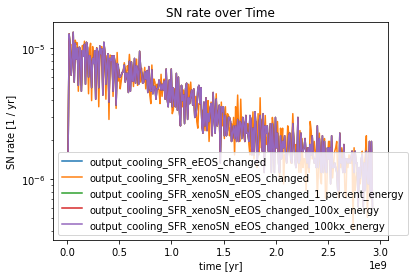

<Figure size 432x288 with 0 Axes>

In [7]:
dataArray = np.full((len(galaxyFolderNames), galaxyFrameAmount), 0, dtype = np.float64)

for i in range(len(galaxyFolderNames)):
    dataArray[i] = calculateOrLoadData(folder = galaxyDataFolders[i], 
                                        folderName = galaxyFolderNames[i], 
                                        dataName = "starsExplodedThisTimeStep", 
                                        calcDataOfOneSnapShotFunction = getStarsExplodedThisTimeStep, 
                                        frameAmount = galaxyFrameAmount, 
                                        recalculate = False)



PlotData(data = dataArray, 
         folderNames = galaxyFolderNames, 
         title = "SN rate over Time", 
         ylabel = "SN rate [1 / yr]", 
         dataName = "starsExplodedThisTimeStep", 
         unit_conversion_factor = 1 / TimeBetSnapshot_in_unit_time / UnitTime_in_yr,
         frameAmount = galaxyFrameAmount, 
         frameNbrMultiplier = galaxyFrameNbrMultiplier,
         compareToAnalyticRadius = False)

### Phase Diagram (Density, Temperature)

-8.795589
-0.2736606
3.97155238455435
6.560582834584094
-8.84709
-0.3759225
3.976479204054185
6.61293343118612
-8.805246
-0.31170034
3.973797366257445
6.611990902055735


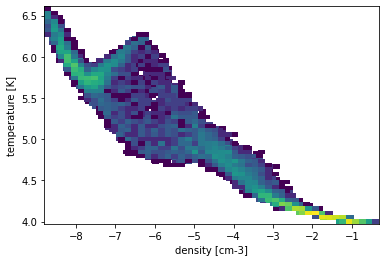

In [11]:
def PlotThis(i):
    folder = galaxyDataFolders[i]
    timeStep = 300
    densities = np.log10(getDensities(folder, timeStep)*UnitDensity_in_cgs /m_p)
    temperatures = np.log10(getTemperaturesInKelvin(folder, timeStep))

    print(np.min(densities))
    print(np.max(densities))
    print(np.min(temperatures))
    print(np.max(temperatures))

    plt.hist2d(densities, temperatures, bins=50, norm = mpl.colors.LogNorm())
    plt.xlabel("density [cm-3]")
    plt.ylabel("temperature [K]")
PlotThis(0)

-8.84709
-0.3759225
3.976479204054185
6.61293343118612


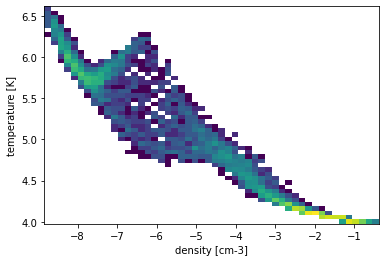

In [26]:
PlotThis(1)

-8.805246
-0.31170034
3.973797366257445
6.611990902055735


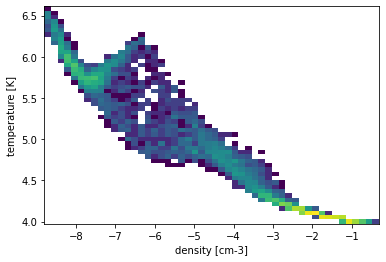

In [10]:
PlotThis(2)